# Model Training (sLDA Features)

Model comparison (XGBoost, RandomForest, Ridge, etc.) with RMSE evaluation, using features derived from sLDA.

To be added from national-news.ipynb soon!

In [1]:
# Load features from 041-feature-engineering.ipynb
import pandas as pd
df_slda = pd.read_csv("../data/processed/features_slda_monthly.csv")

In [2]:
# print preview of the features dataFrame
cols = ['month', 'INDPRO', 'sentiment'] + [c for c in df_slda.columns if c not in ('month', 'INDPRO', 'sentiment')]
display(df_slda[cols].head())

,month,INDPRO,sentiment,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,publication_TMZ,publication_TechCrunch,publication_The Hill,publication_The New York Times,publication_The Verge,publication_Vice,publication_Vice News,publication_Vox,publication_Washington Post,publication_Wired
0,2016-01-01,99.4391,-0.332366,0.113924,0.096957,0.073923,0.136457,0.097931,0.152317,0.141147,...,False,False,False,False,False,False,False,False,False,False
1,2016-01-01,99.4391,-0.359760,0.057679,0.044100,0.071563,0.061600,0.053359,0.114329,0.438747,...,False,False,False,False,False,False,False,False,False,False
2,2016-01-01,99.4391,-0.453634,0.135860,0.049119,0.155220,0.033329,0.082012,0.049961,0.070695,...,False,False,False,False,False,False,False,False,False,False
3,2016-01-01,99.4391,-0.449364,0.035915,0.062259,0.288431,0.050607,0.053273,0.057251,0.194292,...,False,False,False,False,False,False,False,False,False,False
4,2016-01-01,99.4391,-0.171123,0.074303,0.018143,0.032679,0.324294,0.211499,0.059117,0.056758,...,False,False,False,False,False,False,False,False,False,False


In [3]:
df = df_slda.copy() # Use sLDA features

## Compare different models

### 1. Define models and their hyperparameter grids

In [10]:
# VSCode.Cell id="1f6b1b34" language="python"
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    ExtraTreesRegressor
)
from sklearn.linear_model import (
    Ridge,
    Lasso,
    ElasticNet,
    BayesianRidge
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

models_and_params = {
    'XGBoost': {
        'model': XGBRegressor(objective='reg:squarederror', random_state=42),
        'params': {
            'n_estimators': [100, 300],
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.8, 1.0]
        }
    },
    'LightGBM': {
        'model': LGBMRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 300],
            'learning_rate': [0.01, 0.1],
            'num_leaves': [31, 50]
        }
    },
    'CatBoost': {
        'model': CatBoostRegressor(verbose=0, random_state=42),
        'params': {
            'iterations': [100, 300],
            'learning_rate': [0.01, 0.1],
            'depth': [3, 5]
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 300],
            'max_depth': [None, 10],
            'min_samples_split': [2, 5]
        }
    },
    'ExtraTrees': {
        'model': ExtraTreesRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 300],
            'max_depth': [None, 10]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 300],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1.0, 10.0]
        }
    },
    'Lasso': {
        'model': Lasso(random_state=42),
        'params': {
            'alpha': [0.01, 0.1, 1.0]
        }
    },
    'ElasticNet': {
        'model': ElasticNet(random_state=42),
        'params': {
            'alpha': [0.01, 0.1, 1.0],
            'l1_ratio': [0.2, 0.5, 0.8]
        }
    },
    'BayesianRidge': {
        'model': BayesianRidge(),
        'params': {}  # fewer hyperparameters, relies on defaults
    },
    'SVR-RBF': {
        'model': SVR(kernel='rbf'),
        'params': {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto']
        }
    },
    'KNN': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [3, 5, 10],
            'weights': ['uniform', 'distance']
        }
    },
    'MLP': {
        'model': MLPRegressor(random_state=42, max_iter=500),
        'params': {
            'hidden_layer_sizes': [(50,), (100,)],
            'activation': ['relu', 'tanh'],
            'alpha': [0.0001, 0.001]
        }
    }
}

### 2. Time-aware train/test split

In [11]:
# Define features and target
features = [col for col in df.columns if col.startswith('topic_') or col.startswith('publication_')]
features.append('sentiment')
X = df[features]
y = df['INDPRO']

split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Set Up TimeSeriesSplit ---
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

### 3. Run GridSearchCV with 3-fold CV

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

best_models = []
for name, mp in models_and_params.items():
    print(f"\\n🔍 Tuning {name}...") # Corrected f-string to be on a single line
    grid = GridSearchCV(
        estimator=mp['model'],
        param_grid=mp['params'],
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        verbose=0
    )
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    best_models.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'Test RMSE': rmse
    })

\n🔍 Tuning XGBoost...
\n🔍 Tuning LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 946
[LightGBM] [Info] Number of data points in the train set: 254, number of used features: 11
[LightGBM] [Info] Start training from score 98.668845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

c:\Users\javerkin\Dropbox\PhD\Projects\project-ds4pp-eth2025\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\javerkin\Dropbox\PhD\Projects\project-ds4pp-eth2025\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\javerkin\Dropbox\PhD\Projects\project-ds4pp-eth2025\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\javerkin\Dropbox\PhD\Projects\project-ds4pp-eth2025\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimize

### 4. Display results

In [19]:
results_df = pd.DataFrame(best_models).sort_values(by='Test RMSE')
print(results_df)



               Model                                        Best Params  \
9      BayesianRidge                                                 {}   
3       RandomForest  {'max_depth': None, 'min_samples_split': 5, 'n...   
7              Lasso                                    {'alpha': 0.01}   
8         ElasticNet                   {'alpha': 0.01, 'l1_ratio': 0.2}   
2           CatBoost  {'depth': 5, 'iterations': 300, 'learning_rate...   
4         ExtraTrees           {'max_depth': None, 'n_estimators': 300}   
0            XGBoost  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   
6              Ridge                                     {'alpha': 0.1}   
10           SVR-RBF                        {'C': 10, 'gamma': 'scale'}   
11               KNN           {'n_neighbors': 5, 'weights': 'uniform'}   
1           LightGBM  {'learning_rate': 0.1, 'n_estimators': 100, 'n...   
5   GradientBoosting  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
12               MLP  {'a

### 5. Visualization

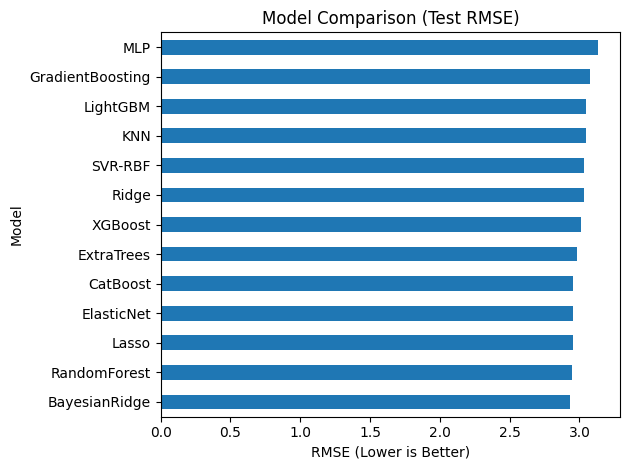

In [20]:
import matplotlib.pyplot as plt

results_df.plot(x='Model', y='Test RMSE', kind='barh', legend=False, title='Model Comparison (Test RMSE)')
plt.xlabel("RMSE (Lower is Better)")
plt.tight_layout()
plt.show()

### 6. Save Best Models

In [22]:
# Save best models
import joblib
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, BayesianRidge # Added BayesianRidge

# 1) Identify best model by lowest RMSE
best_idx     = results_df['Test RMSE'].idxmin()
best_name    = results_df.loc[best_idx, 'Model']
best_params  = results_df.loc[best_idx, 'Best Params']

# 2) Re‐instantiate and fit on full training set
if best_name == 'XGBoost':
    best_model = XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)
elif best_name == 'RandomForest':
    best_model = RandomForestRegressor(random_state=42, **best_params)
elif best_name == 'GradientBoosting':
    best_model = GradientBoostingRegressor(random_state=42, **best_params)
elif best_name == 'Ridge':
    best_model = Ridge(**best_params)
elif best_name == 'BayesianRidge': # Added this condition
    best_model = BayesianRidge(**best_params)
else:
    raise ValueError(f"Unknown model: {best_name}")

best_model.fit(X_train, y_train)

# 3) Save to disk for later use (e.g. SHAP analysis)
model_path = "../models/best_slda_model.joblib" # Changed filename
joblib.dump(best_model, model_path)
print(f"✅ Saved best model ({best_name}) to {model_path}")


✅ Saved best model (BayesianRidge) to ../models/best_slda_model.joblib
